# hyperspectral-images

Spectral Unmixing & Classification.

---
> **Assignee** <br />
> full name: Antonopoulos Ilias <br />
> email: iantonopoulos@aueb.gr <br />
> ID: P3352004 <br />
> course: Machine Learning and Computational Statistics (M36104P) <br />
> program: MSc in Data Science (PT)
---

# Table of Contents

- [Reproducibility]()
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Spectral Unmixing](#Spectral-Unmixing)
 - [Least Squares with no constraints](#(a)-Least-Squares,-with-no-constraints)
 - [Least Squares with a sum-to-one constraint](#(b)-Least-Squares,-with-a-sum-to-one-constraint)
 - [Least Squares with a non-negativity constraint](#(c)-Least-Squares,-with-a-non-negativity-constraint)
 - [Least Squares with sum-to-one & non-negativity constraints](#(d)-Least-Squares,-with-sum-to-one-&-non-negativity-constraints)
 - [LASSO](#(e)-LASSO)
 - [Comparison and remarks](#Spectral-Unmixing---Comparison-and-Remarks)
- [Classification](#Classification)
 - [Naive Bayes Classifier](#Naive-Bayes-Classifier)
 - [minimum Euclidean distance classifier](#minimum-Euclidean-distance-classifier)
 - [k-nearest neighbor classifier](#k-nearest-neighbor-classifier)
 - [Bayesian-classifier](#Bayesian-classifier)
 - [Comparison and remarks](#Classification---Comparison-and-Remarks)
- [Combination]()

# Reproducibility

To easily reproduce the results of this Jupyter notebook, in a clean & efficient manner, do read the following:

Assuming that a [Python](https://www.python.org/) (v3.6.x or greater) is installed in your system:

- you should (optionally) upgrade `pip`:

```shell
python -m pip install --upgrade pip
```

- you should install all the necessary dependencies (see below)

**note**: the usage of a [virtual environment](https://docs.python.org/3/tutorial/venv.html#creating-virtual-environments) for this is highly advised, in order to keep your system-wide Python interpreter clean of unnecessary dependencies such as `scikit-learn` etc.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import scipy.optimize

from scipy.spatial import distance
from scipy.stats import multivariate_normal, norm
from sklearn import linear_model, discriminant_analysis
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

## Exploratory Data Analysis

We'll begin by loading all the available data, trying to develop an initial understanding of the problem at hand.

In [2]:
salinas = sio.loadmat('data/Salinas_cube.mat')

salinas.keys()

dict_keys(['__header__', '__version__', '__globals__', 'salinas_cube'])

In [3]:
hsi = salinas['salinas_cube']

hsi.shape

(220, 120, 204)

In [4]:
ends = sio.loadmat('data/Salinas_endmembers.mat')

ends

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Mar 23 15:44:08 2021',
 '__version__': '1.0',
 '__globals__': [],
 'salinas_endmembers': array([[392.98079561, 388.55390904, 325.42702051, ..., 446.79332153,
         345.42833194, 306.5428824 ],
        [496.35070873, 504.777721  , 418.4185766 , ..., 585.49152542,
         430.39340598, 398.5928382 ],
        [702.8079561 , 735.25140521, 630.0747889 , ..., 838.19251202,
         574.78066499, 566.7683466 ],
        ...,
        [  4.96799268,  48.75217169,  28.2907117 , ...,  31.76979509,
           4.73959206,  15.29619805],
        [  1.9304984 ,  17.03628002,   9.76839566, ...,  11.04528206,
           1.76809165,   5.29045093],
        [  2.83539095,  27.07307103,  15.36670688, ...,  17.61801164,
           2.63593182,   8.59195402]])}

In [5]:
endmembers = ends['salinas_endmembers']

endmembers.shape

(204, 7)

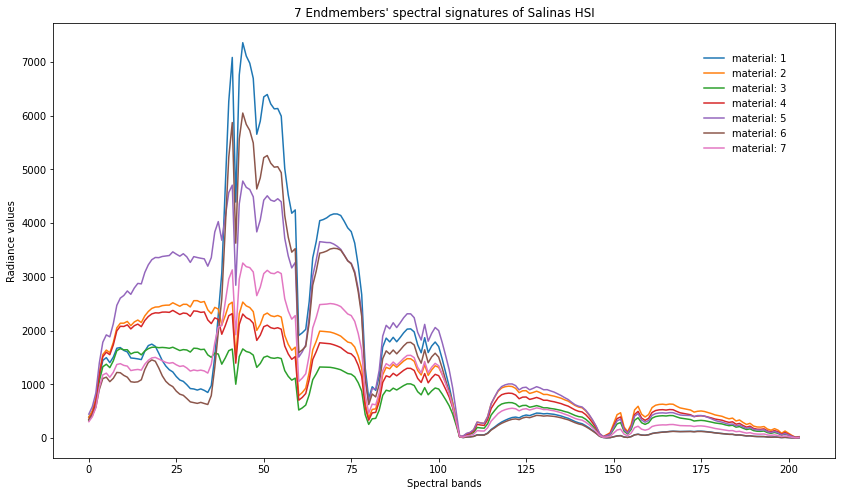

In [6]:
fig = plt.figure(figsize=(14, 8))

plt.plot(endmembers)
plt.legend(['material: {}'.format(i + 1) for i in range(7)], bbox_to_anchor=(0.95, 0.95), framealpha=0)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title("7 Endmembers' spectral signatures of Salinas HSI")

plt.show()

In [7]:
ground_truth = sio.loadmat('data/Salinas_gt.mat')

ground_truth

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Mar  1 23:21:46 2021',
 '__version__': '1.0',
 '__globals__': [],
 'salinas_gt': array([[0, 0, 0, ..., 0, 0, 0],
        [6, 6, 6, ..., 0, 0, 0],
        [6, 6, 6, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [8]:
labels = ground_truth['salinas_gt']

labels.shape

(220, 120)

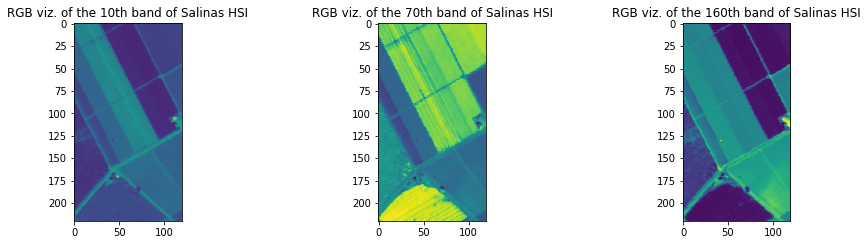

In [9]:
fig = plt.figure(figsize=(20, 8))

ax = fig.add_subplot(2,2,1)

ax.imshow(hsi[:, :, 10])
ax.set_title('RGB viz. of the 10th band of Salinas HSI')

ax = fig.add_subplot(2,3,2)

ax.imshow(hsi[:, :, 70])
ax.set_title('RGB viz. of the 70th band of Salinas HSI')

ax = fig.add_subplot(2,2,2)

ax.imshow(hsi[:, :, 160])
ax.set_title('RGB viz. of the 160th band of Salinas HSI')

plt.show()

We can definitely see an area with landfields, a partial road network etc.

According to the dataset specification, it is an area of the [Salinas valley](https://en.wikipedia.org/wiki/Salinas_Valley) in California, USA.

In [10]:
salinas_labels = sio.loadmat('data/classification_labels_Salinas.mat')

salinas_labels

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Mar  1 16:49:08 2021',
 '__version__': '1.0',
 '__globals__': [],
 'operational_set': array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=uint8),
 'test_set': array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=uint8),
 'training_set': array([[0],
        [6],
        [6],
        ...,
        [0],
        [0],
        [0]], dtype=uint8)}

# Spectral Unmixing

In this first part, our aim is to perform spectral unmixing on each one of the pixels in the image with
nonzero label, with respect to the $m = 7$ endmembers.

We adopt the **linear spectral unmixing hypothesis**:

$$ y = X \theta + \eta $$

where:

- $y$ is the $L$-dimensional spectral signature of the pixel under study
- $X$ is composed by the spectral signatures $x_1, \dots, x_m$ of the pure pixels (i.e. pure materials) in the image - they are also $L$-dimensional columns
- $\theta$ is the $m$-dimensional abundance vector of the pixel
- $\eta$ is the $L$-dimensional i.i.d., zero-mean Gaussian noise vector

We also define the reconstruction error as follows:

$$ \cfrac{1}{N} \sum_{n=1}^N \lVert y_i - X \theta_i \rVert^2 $$

**note**: in our particular problem, $N$ designates the total number of pixels in the image with non-zero label.

In [11]:
# we will filter-out the pixels with zero label
xi, yi = np.nonzero(labels)

nonzero_hsi = hsi[xi, yi]

nonzero_hsi.shape

(16929, 204)

We will firstly approach this task via the unconstrained Least Squares method.

That is, we will solve the problem:

$$ \text{argmin}_{\theta} J(\theta), \phantom{o} \text{where} \phantom{o} J(\theta) = \lVert y - X \theta \rVert^2 $$

It can be shown that: $$ \hat{\theta} = (X^TX)^{-1} X^Ty$$

In [12]:
def unconstrained_least_squares_solver(image, endmembers):
    """Implements a Least Squares solver, assuming no constraints.
    
    Args:
        image: an (x, l) array, that contains non-zero pixels.
        endmembers: an (l, 7) array.
    
    Returns:
        The Least Squares solution, as an (7, x) array, containing the unmixing estimates.
    """
    inverse = np.linalg.inv(np.dot(endmembers.T, endmembers))
    
    return inverse.dot(endmembers.T).dot(image.T)

In [13]:
def abundance_maps(estimates, xi, yi):
    """Plots the abundance maps for the 7 materials.
    
    Args:
        estimates: an (7, x) array, containing the unmixing estimates.
        xi: a (x,) array with the non-zero x positions of pixels.
        yi: a (x,) array with the non-zero y positions of pixels

    Returns:
        The abundance maps.
    """
    fig, axs = plt.subplots(3, 3, figsize=(20, 20), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    
    abundance_maps = np.zeros((225, 130, 7))
    
    for i in range(7):

        abundance_maps[xi, yi, i] = estimates[i, :]

        axs[i].imshow(abundance_maps[:, :, i])
        axs[i].set_title('material: {}'.format(i + 1))
        axs[i].grid(False)

    fig.tight_layout()
    
    # remove 8th and 9th subplot entry of the 3x3 grid
    fig.delaxes(axs[-1])
    fig.delaxes(axs[-2])

In [14]:
def reconstruction_error(image, endmembers, labels, estimates):
    """Implements the reconstruction error metric.
    
    Args:
        image: an (x, l) array, that contains non-zero pixels.
        endmembers: an (l, 7) array.
        labels: an (m, n) array.
        estimates: an (7, x) array, containing the unmixing estimates.
    
    Returns (float):
        The reconstruction error.
    """
    n = np.count_nonzero(labels)
    
    return np.linalg.norm(image.T - np.dot(endmembers, estimates)) ** 2 / n

Let's proceed with the calculations:

In [15]:
estimation1 = unconstrained_least_squares_solver(nonzero_hsi, endmembers)

estimation1.shape

(7, 16929)

In [16]:
error1 = reconstruction_error(nonzero_hsi, endmembers, labels, estimation1)

print('method: unconstrained Least Squares')
print(f'reconstruction error: {error1}\n')

method: unconstrained Least Squares
reconstruction error: 35058.88066277267



abundance map per endmember/material:


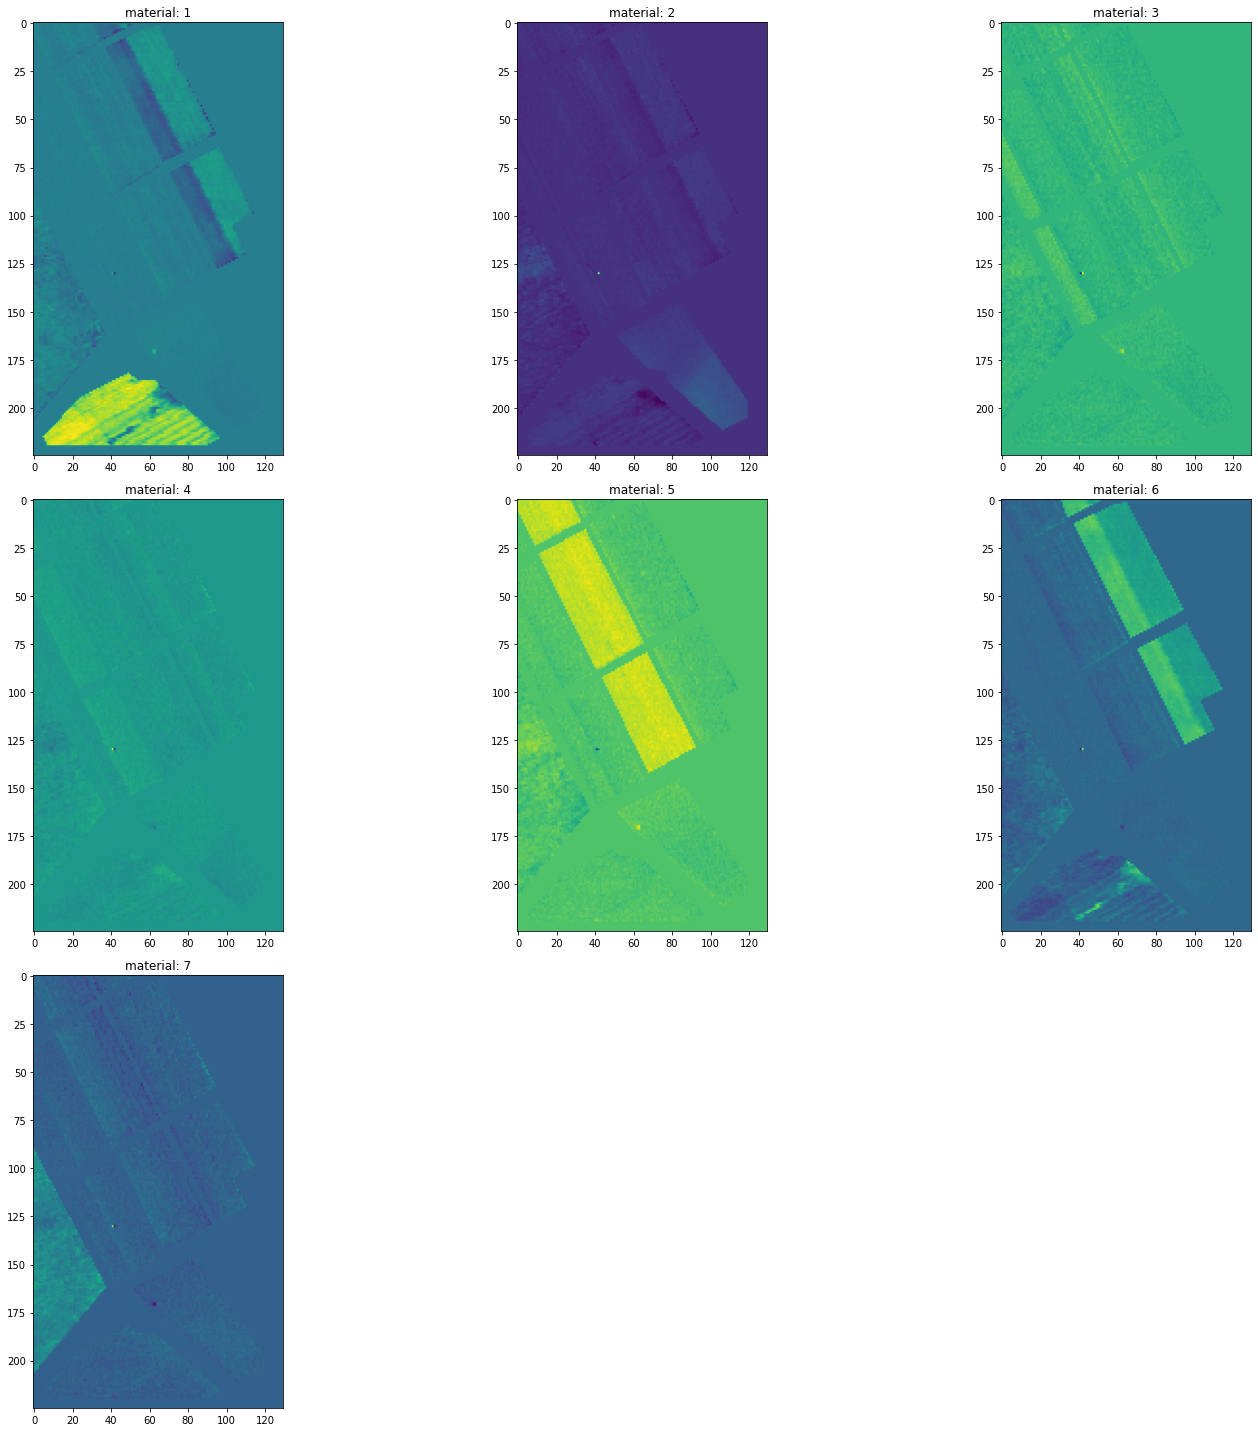

In [17]:
print('abundance map per endmember/material:')

abundance_maps(estimation1, xi, yi)

In [18]:
def visualize_estimates(estimates):
    """Visualizes the estimates across materials.
    
    Args:
        estimates: an (7, x) array, containing the unmixing estimates.
    
    Returns:
        The visualization.
    """
    fig = plt.figure(figsize=(14, 8))
    
    ax = fig.add_subplot(111)
    
    ax.hist(np.sum(estimates, axis=0),
            density=True, 
            bins=30)
    
    ax.set_title('$\sum_1^7 \\theta_i$')

    plt.show()

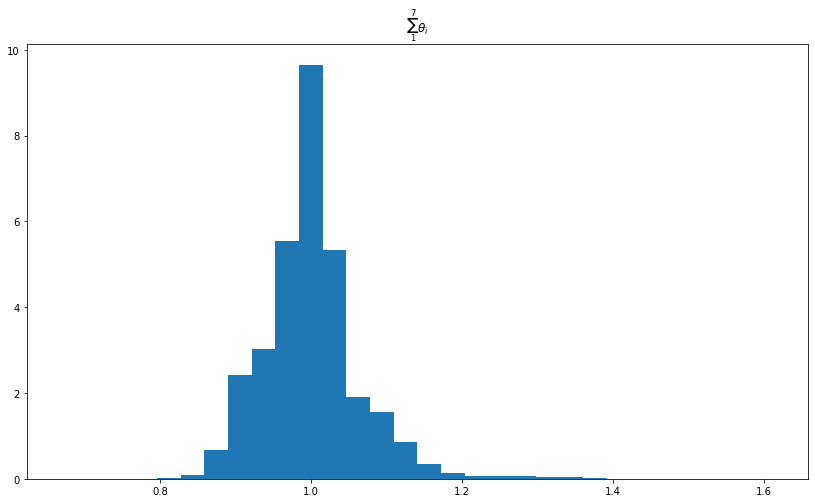

In [19]:
visualize_estimates(estimation1)

### (b) Least Squares, with a sum-to-one constraint

We will now include a sum-to-one constraint to our Least Squares problem:

That is, we will solve the problem:

$$ \text{argmin}_{\theta} J(\theta), \phantom{o} \text{where} \phantom{o} J(\theta) = \lVert y - X \theta \rVert^2, \phantom{o} \text{subject to} \sum_{i=1}^7 \theta_i = 1$$

There are a couple of ways to subject the problem to the sum-to-one constraint. Namely:
- solve the unconstrained problem and perform suitable post-transformation to recover the under-constraint solution 
- introduce constraint as an extra problem equation, along with a weighting policy in favor of this equation, so as to "force" solution to uphold constraint.
- etc.

We will utilize the [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) function.

In [20]:
def sum_to_one_squares_solver(image, endmembers, labels):
    """Implements a Least Squares solver, assuming the sum-to-one constraint.
    
    Args:
        image: an (x, l) array, that contains non-zero pixels.
        endmembers: an (l, 7) array.
        labels: an (m, n) array.
    
    Returns:
        The Least Squares solution, as an (7, x) array, containing the unmixing estimates.
    """
    # define objective function
    def obj_func(x, a, b):
        return np.linalg.norm(a.dot(x) - b) ** 2
    
    # define constraint(s)
    constraints = {'type': 'eq', 'fun': lambda y: np.sum(y) - 1}  
    
    # define minimization strategy
    def minimizer(c):
        
        inits = np.zeros((1, 7))
        
        for i in range(c):
            
            res = scipy.optimize.minimize(
                obj_func, 
                inits, 
                args=(endmembers, image[i, :]),
                method='SLSQP',
                tol='1e-6',
                constraints=constraints,
            )
            
            yield res.x
    
    n = np.count_nonzero(labels)
    
    return np.array([*minimizer(n)]).T

In [21]:
estimation2 = sum_to_one_squares_solver(nonzero_hsi, endmembers, labels)

estimation2.shape

(7, 16929)

In [22]:
error2 = reconstruction_error(nonzero_hsi, endmembers, labels, estimation2)

print('method: Least Squares with sum-to-one constraint')
print(f'reconstruction error: {error2}\n')

method: Least Squares with sum-to-one constraint
reconstruction error: 43082.576302782494



abundance map per endmember/material:


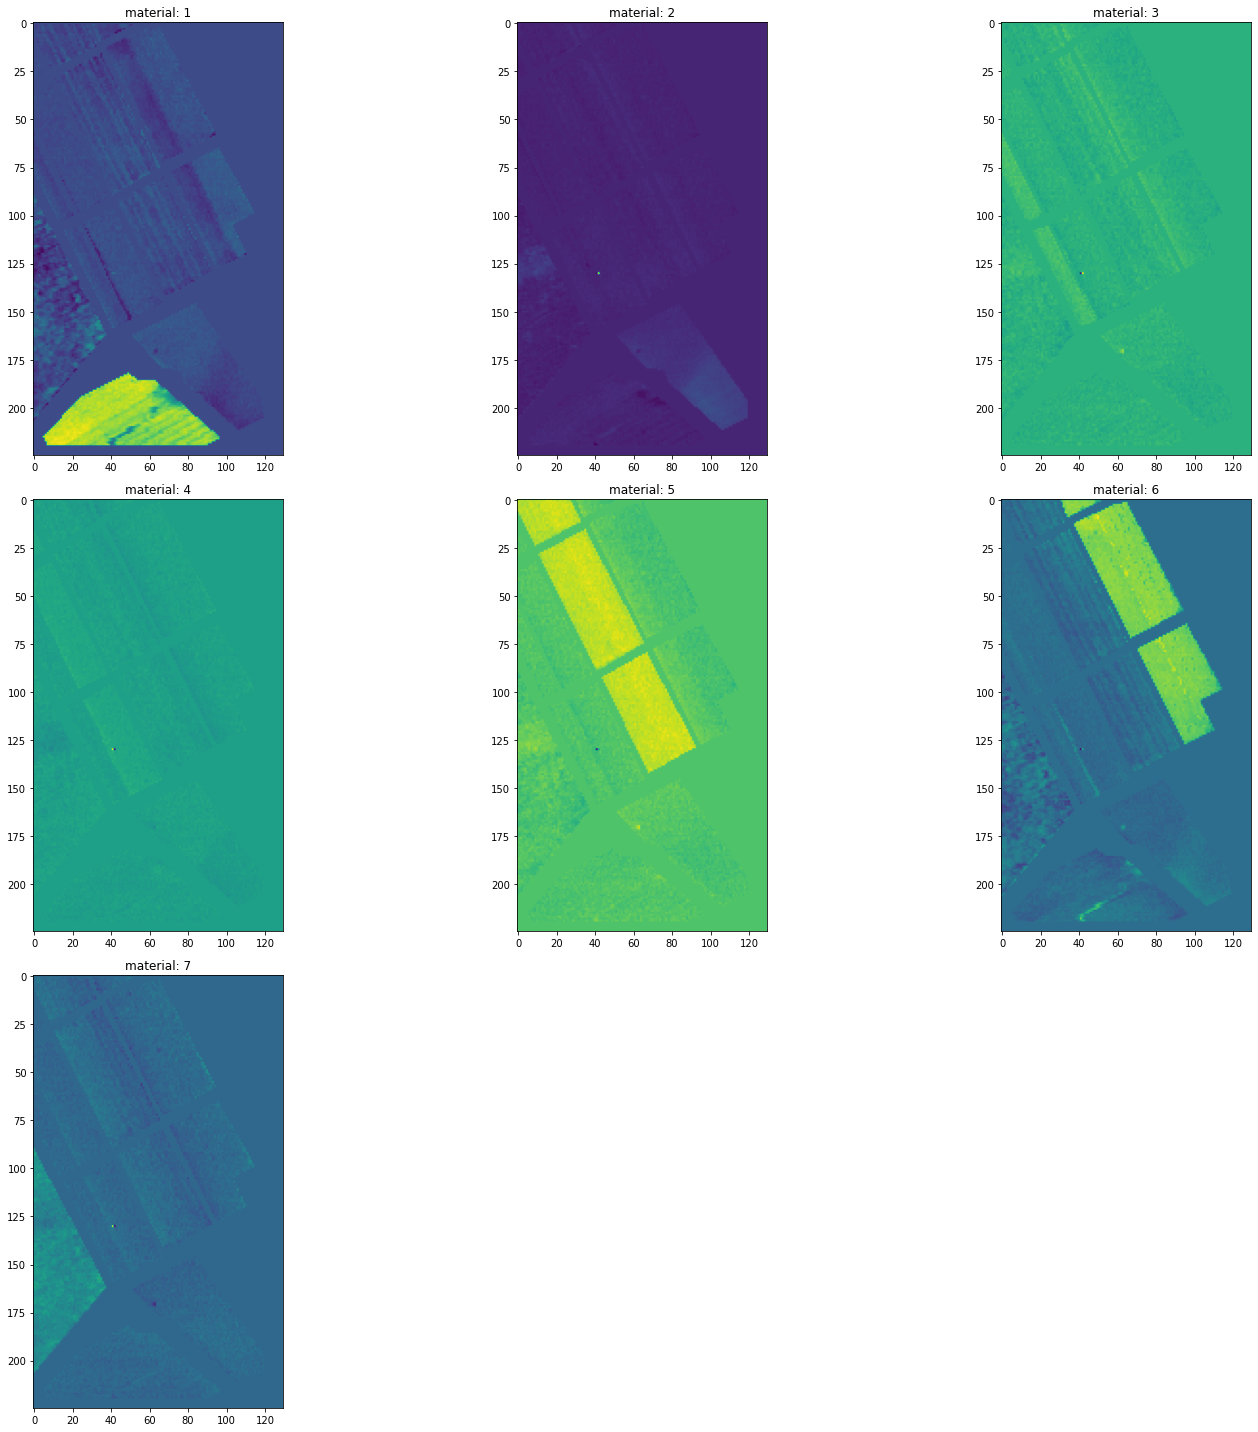

In [23]:
print('abundance map per endmember/material:')

abundance_maps(estimation2, xi, yi)

In [24]:
np.sum(estimation2, axis=0)

array([1., 1., 1., ..., 1., 1., 1.])

In [25]:
np.sum(np.sum(estimation2, axis=0))

16929.0

The estimated params indeed respect the sum-to-one constraint.

### (c) Least Squares, with a non-negativity constraint

We will now attempt to solve the LS problem, by introducing a non-negativity constraint:

$$ \text{argmin}_{\theta} J(\theta), \phantom{o} \text{where} \phantom{o} J(\theta) = \lVert y - X \theta \rVert^2, \phantom{o} \text{subject to} \phantom{o} \theta \geq 0 $$

A key observation here is that we cannot use a direct approach as in **(a)** but rather an iterative algorithm is required.

Since this is a straightforward restriction (enforcing bounds on the values a parameter can get) we will utilize the respective open-source implementation: [scipy.optimize.nnls](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.nnls.html)

In [26]:
def nonnegative_least_squares_solver(image, endmembers, labels):
    """Implements a Least Squares solver, assuming the non-negativity constraint.
    
    Args:
        image: an (x, l) array, that contains non-zero pixels.
        endmembers: an (l, 7) array.
        labels: an (m, n) array.
    
    Returns:
        The Least Squares solution, as an (7, x) array, containing the unmixing estimates.
    """
    def optimizer(c):
        
        for i in range(c):
            
            theta, _ = scipy.optimize.nnls(endmembers, image[i, :])
            
            yield theta
            
    n = np.count_nonzero(labels)
    
    return np.array([*optimizer(n)]).T

In [27]:
estimation3 = nonnegative_least_squares_solver(nonzero_hsi, endmembers, labels)

estimation3.shape

(7, 16929)

In [28]:
error3 = reconstruction_error(nonzero_hsi, endmembers, labels, estimation3)

print('method: Least Squares with non-negativity constraint')
print(f'reconstruction error: {error3}\n')

method: Least Squares with non-negativity constraint
reconstruction error: 156104.18220644674



abundance map per endmember/material:


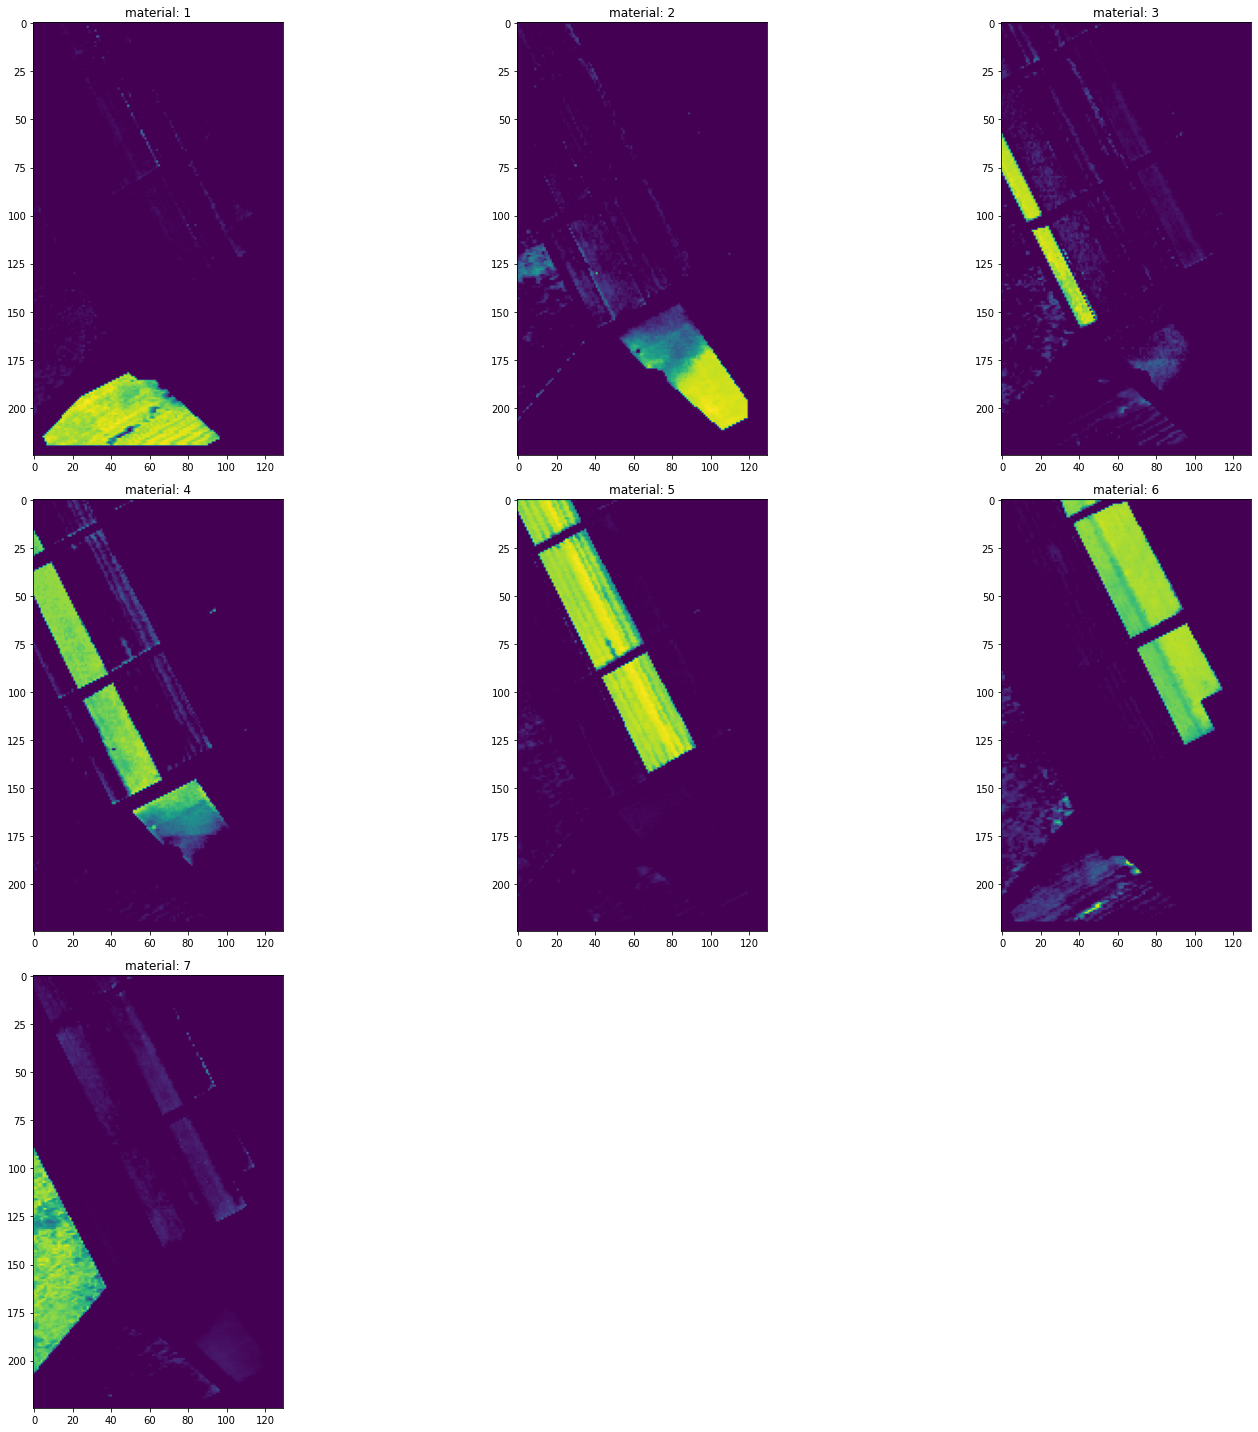

In [29]:
print('abundance map per endmember/material:')

abundance_maps(estimation3, xi, yi)

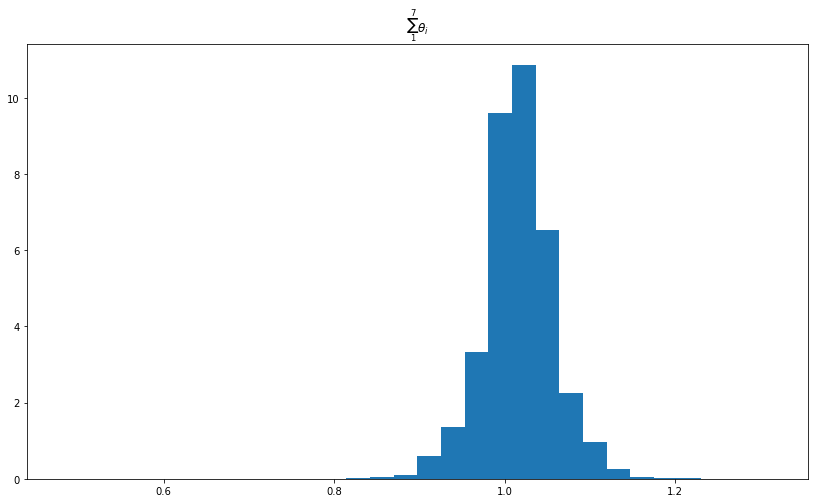

In [30]:
visualize_estimates(estimation3)

### (d) Least Squares, with sum-to-one & non-negativity constraints

We will now combine the previous two, by introducing a non-negativity constraint as well as a sum-to-one constraint:

$$ \text{argmin}_{\theta} J(\theta), \phantom{o} \text{where} \phantom{o} J(\theta) = \lVert y - X \theta \rVert^2, \phantom{o} \text{subject to} \phantom{o} \theta \geq 0 \phantom{o}\text{and}\phantom{o}  \sum_{i=1}^7 \theta_i = 1$$

Again, an iterative algorithm is required to solve the problem. We will again go with [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) function.

Before going into the implementation details, it is worth noting that something like:

$$\theta = [1/7, \dots, 1/7]^T$$

is a reasonable parameter configuration, since both constraints need to be upheld.

Let's see how it plays out in practice.

In [31]:
def nn_and_sum_to_one_squares_solver(image, endmembers, labels):
    """Implements a Least Squares solver, assuming the sum-to-one and non-negativity constraints.
    
    Args:
        image: an (x, l) array, that contains non-zero pixels.
        endmembers: an (l, 7) array.
        labels: an (m, n) array.
    
    Returns:
        The Least Squares solution, as an (7, x) array, containing the unmixing estimates.
    """
    # define objective function
    def obj_func(x, a, b):
        return (np.linalg.norm(a.dot(x) - b)) ** 2
    
    # define constraint(s)
    constraints = [
        {'type': 'eq', 'fun': lambda y: 1 - np.sum(y)}
    ]
    bounds = [(0, None)] * endmembers.shape[1]

    # define minimization strategy
    def minimizer(c):
        
        initial_guess = np.ones((1, 7)) * (1/7)
        
        for i in range(c):
            
            res = scipy.optimize.minimize(
                obj_func, 
                x0=initial_guess, 
                args=(endmembers, image[i, :]),
                bounds=bounds,
                method='SLSQP',
                tol='1e-6',
                constraints=constraints,
            )
            
            yield res.x
    
    n = np.count_nonzero(labels)
    
    return np.array([*minimizer(n)]).T

In [32]:
estimation4 = nn_and_sum_to_one_squares_solver(nonzero_hsi, endmembers, labels)

estimation4.shape

(7, 16929)

In [33]:
error4 = reconstruction_error(nonzero_hsi, endmembers, labels, estimation4)

print('method: Least Squares with sum-to-one + non-negativity constraints')
print(f'reconstruction error: {error4}\n')

method: Least Squares with sum-to-one + non-negativity constraints
reconstruction error: 83607075.37929074



abundance map per endmember/material:


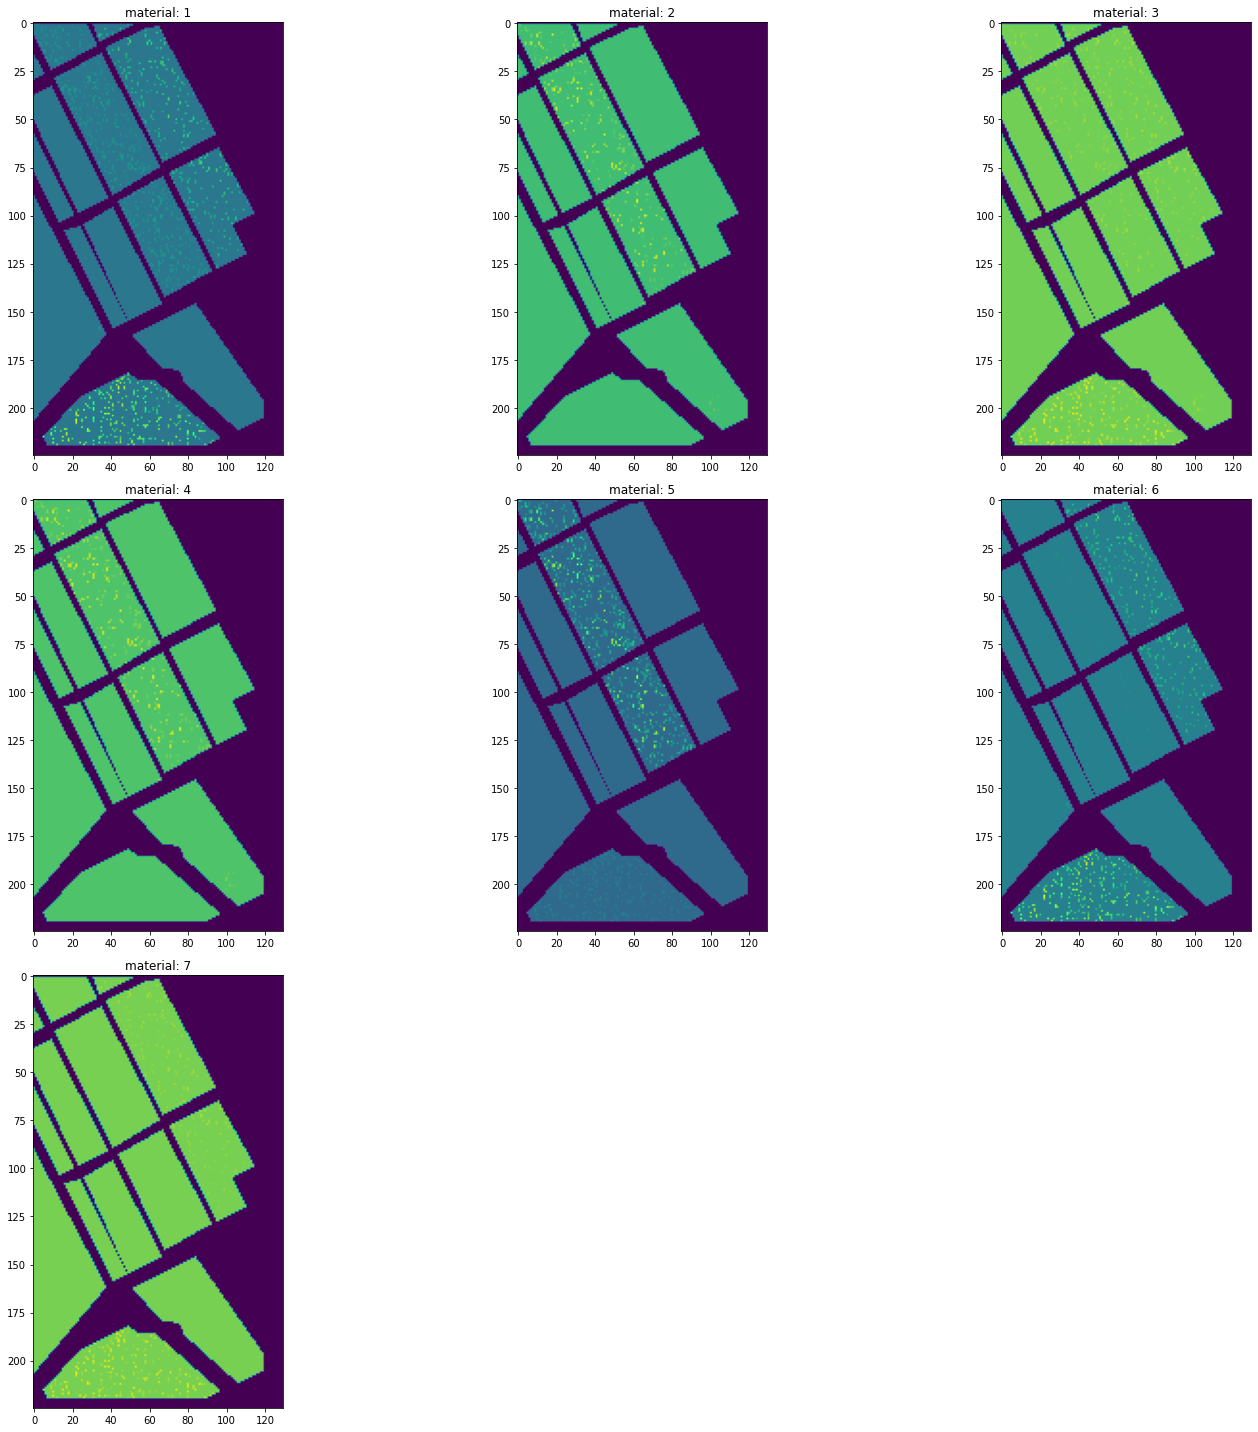

In [34]:
print('abundance map per endmember/material:')

abundance_maps(estimation4, xi, yi)

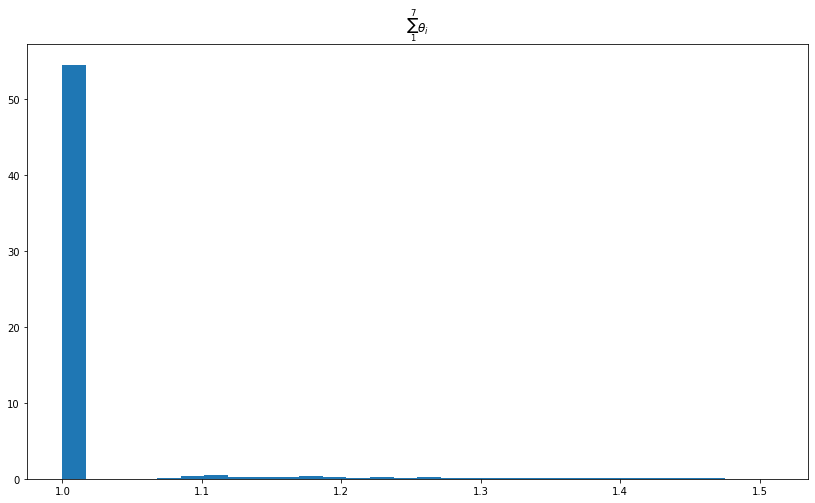

In [35]:
visualize_estimates(estimation4)

### (e) LASSO

We would now try to impose a sparsity on $\theta$, via LASSO and $L_1$ norm minimization.

That is, we would like to solve the following regularized Least Squares problem:

$$ \text{argmin}_{\theta} J(\theta), \phantom{o} \text{where} \phantom{o} J(\theta) = \lVert y - X \theta \rVert^2, \phantom{o} \text{subject to} \phantom{o} \lVert \theta \rVert_1 \leq \rho $$

We will utilize the [scikit-learn-provided](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) LASSO i.e. a linear model trained with $L_1$ prior as regularizer.

A low reconstruction error can be yielded by a Lagrangian of `37`.

In [36]:
def lasso_least_squares_solver(image, endmembers, labels):
    """Implements a Least Squares solver, with a LASSO regularization scheme.
    
    Args:
        image: an (x, l) array, that contains non-zero pixels.
        endmembers: an (l, 7) array.
        labels: an (m, n) array.
    
    Returns:
        The Least Squares solution, as an (7, x) array, containing the unmixing estimates.
    """
    clf = linear_model.Lasso(alpha=37, positive=True, fit_intercept=False, max_iter=1e7)
    
    def optimizer(c):
        
        for i in range(c):
            
            clf.fit(endmembers, image[i, :])
            
            yield clf.coef_
    
    n = np.count_nonzero(labels)
    
    return np.array([*optimizer(n)]).T

In [37]:
estimation5 = lasso_least_squares_solver(nonzero_hsi, endmembers, labels)

estimation5.shape

(7, 16929)

In [38]:
error5 = reconstruction_error(nonzero_hsi, endmembers, labels, estimation5)

print('method: LASSO')
print(f'reconstruction error: {error5}\n')

method: LASSO
reconstruction error: 158097.38670329918



abundance map per endmember/material:


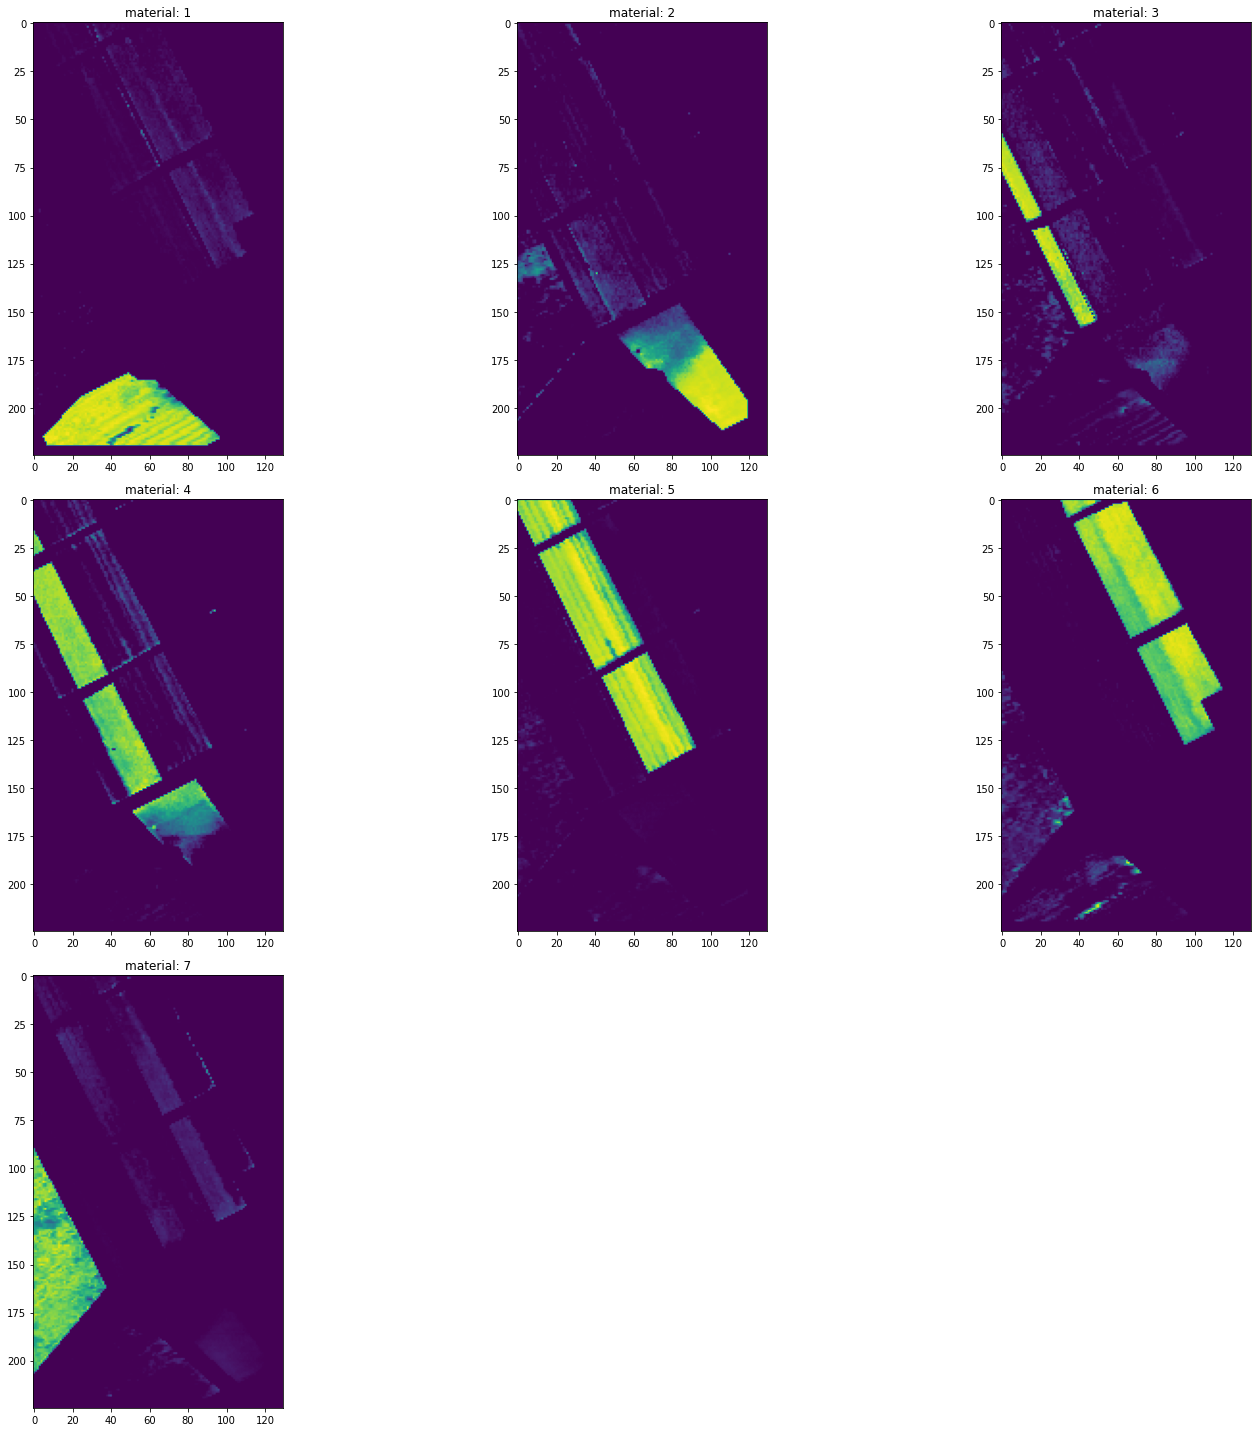

In [39]:
print('abundance map per endmember/material:')

abundance_maps(estimation5, xi, yi)

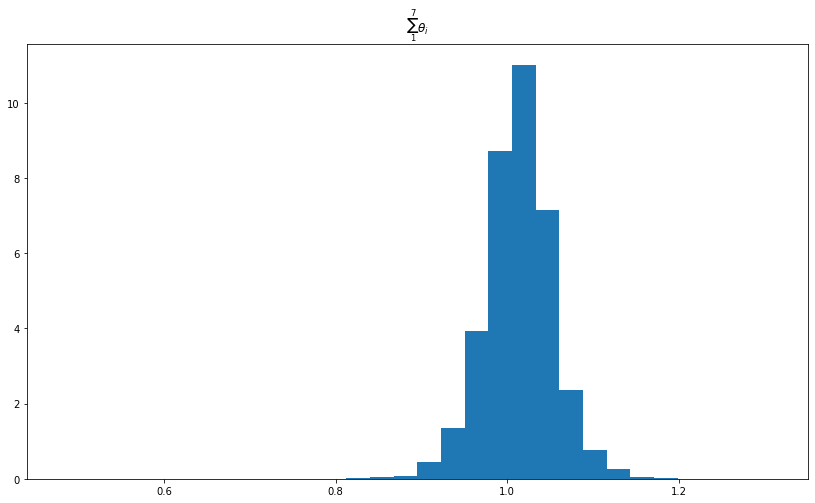

In [40]:
visualize_estimates(estimation5)

### Spectral Unmixing - Comparison and Remarks

Before commenting on the results, let's visually compare the reconstruction errors.

In [41]:
errors = [error1, error2, error3, error4, error5]

method_names = ['Unconstrained LS', 'sum-to-one LS', 'nn LS', 'sum-to-one + nn LS', 'LASSO']

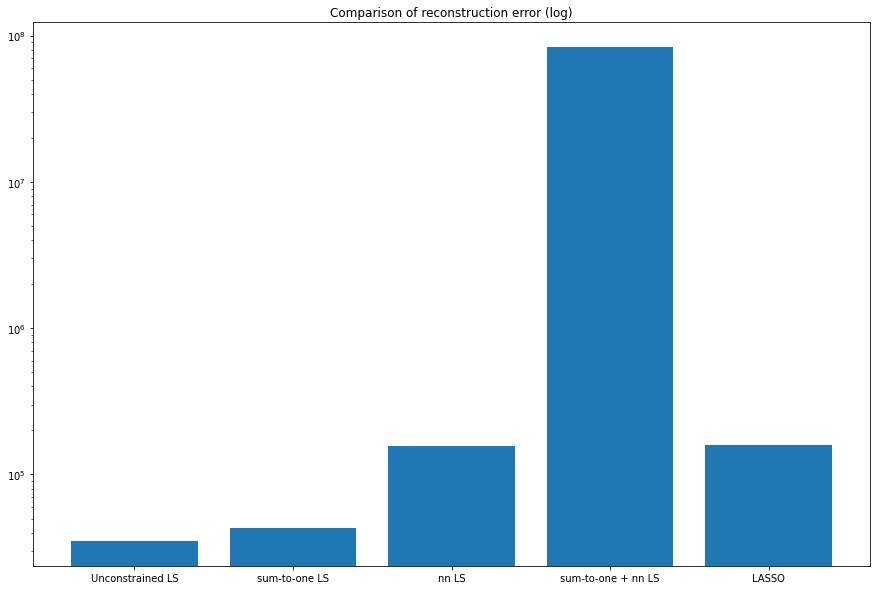

In [42]:
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(111)

ax.set_title('Comparison of reconstruction error (log)')

ax.bar(method_names, errors, align='center')
ax.set_yscale('log')

plt.show()

We can also plot a definitive graph of the abundance maps, along with the labels, to fully assess the spectral unmixing performance of each approach.

In [43]:
def get_full_image(image):
    
    temp = np.zeros((225, 130))

    temp[xi, yi] = image
    
    return temp

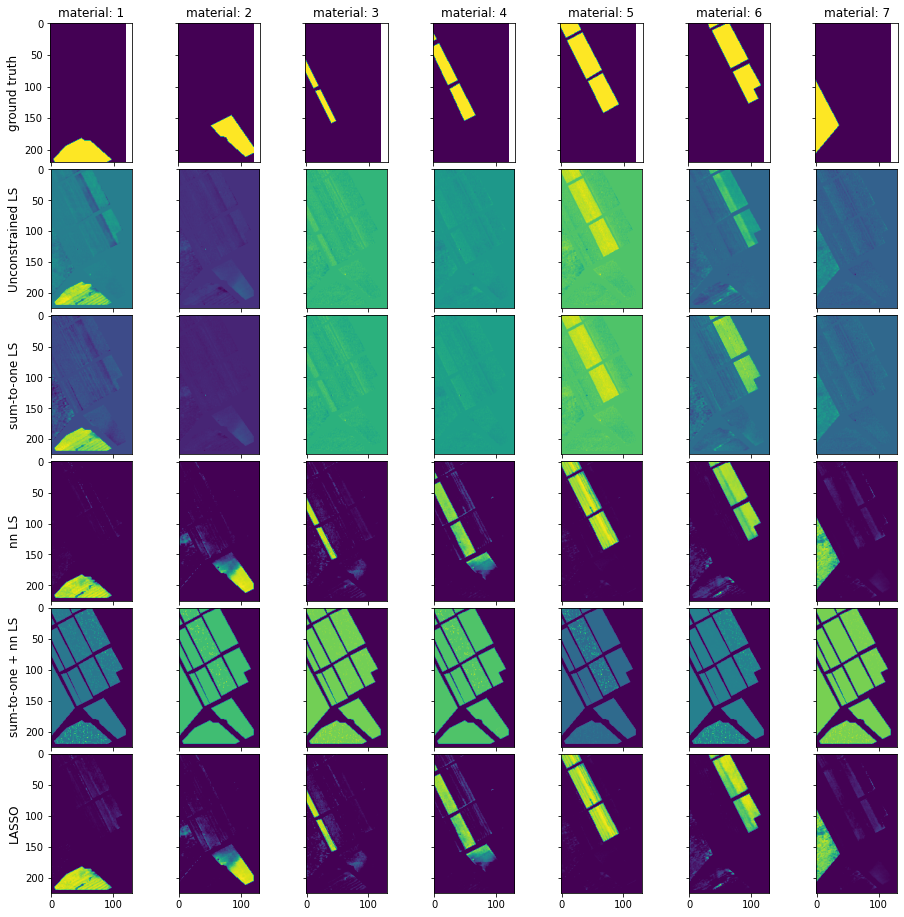

In [44]:
plotset = ['ground truth'] + method_names

fig, axs = plt.subplots(6, 7, figsize=(16, 16), facecolor='w', edgecolor='k', sharex='col', sharey='row')

fig.subplots_adjust(hspace=.3, wspace=.001)

for i in range(7):
    
    # ground-truth
    axs[0,i].imshow(labels == (i + 2 if i + 2 != 8 else 1))  # labels is not properly ordered!

    # LS approaches
    axs[1, i].imshow(get_full_image(estimation1[i, :]))
    axs[2, i].imshow(get_full_image(estimation2[i, :]))
    axs[3, i].imshow(get_full_image(estimation3[i, :]))
    axs[4, i].imshow(get_full_image(estimation4[i, :]))
    axs[5, i].imshow(get_full_image(estimation5[i, :]))
    
    axs[0,i].set_title('material: {}'.format(i + 1), rotation=0, size='large')
    
    if i < 6:
        axs[i, 0].set_ylabel(plotset[i], rotation=90, size='large')
            

plt.subplots_adjust(wspace=0, hspace=0.05)

Based on all the above, we have found that:

- the unconstrained LS method yielded the smallest reconstruction error
- the LS method with sum-to-one and non-negativity constraints imposed, yielded the largest (worse) reconstruction error.
- the sum-to-one LS method maintained a reconstruction error that is comparable to the unconstrained version, while at the same time respecting the sum-to-one constraint, which in itself is very important as it provides more natural inference on the true abundance of each material.

Another thing worth mentioning is that the LS methods that included the non-negativity constraint had slower convergence optimization-wise and also scored higher reconstruction errors. This is probably related to the fact that optimization problems where only equalities are involved are much easier than problems where inequality conditions need to be upheld.

With respect to the abundance maps, we can see that:

- all approaches, except for the fully-constrained one, managed to separate the materials to a fair extent.
- in these case and when juxtaposed with the ground truth, there is also a correct correspondence of the materials (i.e. no mismatches)
- the fully-constrained method completely failed to the unmixing task, which is also clearly visible.
- the non-negativity-only LS and the LASSO produced highly contrastive abundance maps with clearly defined geographical boundaries, but at the same time they were not competitive in terms of reconstruction error to the sum-to-one, unconstrained approaches. It is logical, since both methods have restrictions (e.g. sparsity for LASSO) that tend to "amplify" the estimation process (for better or for worse, however).

# Classification

We again consider only the image pixels with non-zero class label.

Our goal is to assign each one of them to the most appropriate class, among the **7** known classes.

We will do so, with the following 4 classifiers:

- **Naive Bayes classifier**
- **minimum Euclidean distance classifier**
- **k-nearest neighbor classifier**
- **Bayesian classifier**

In [45]:
training_set = (np.reshape(salinas_labels['training_set'], (120, 220))).T
test_set = (np.reshape(salinas_labels['test_set'], (120, 220))).T
operational_set = (np.reshape(salinas_labels['operational_set'], (120, 220))).T

In [46]:
training_set.shape

(220, 120)

In [47]:
test_set.shape

(220, 120)

In [48]:
operational_set.shape

(220, 120)

In [49]:
labels.shape

(220, 120)

Let's visualize the datasets, to get a better idea.

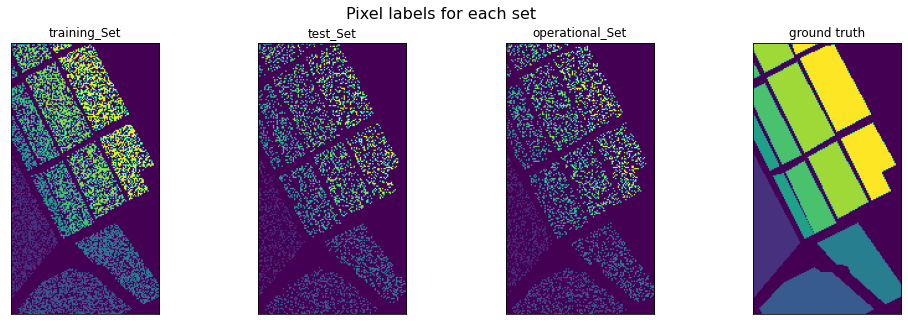

In [50]:
fig, axs = plt.subplots(1, 4, figsize=(17, 5), sharey=True)

fig.suptitle('Pixel labels for each set', fontsize=16)

axs[0].imshow(training_set)
axs[0].set_title('training_Set')
axs[0].set_xticks([])

axs[1].imshow(test_set)
axs[1].set_title('test_Set')
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(operational_set)
axs[2].set_title('operational_Set')
axs[2].set_xticks([])
axs[2].set_yticks([])

axs[3].imshow(labels)
axs[3].set_title('ground truth')
axs[3].set_xticks([])
axs[3].set_yticks([])
plt.show()

**(i)** We will train each classifier on the training set, performing a 10-fold cross-validation. We will report the estimated validation error by averaging over the 10 result sets, along with the respective standard deviation.

**(ii)** We will then use the whole training set to train the classifier and evaluate each performance on the test set:

- via the confusion matrix
- by computing the success rate

In [51]:
X_train = hsi[training_set != 0]
y_train = training_set[training_set != 0]

print(X_train.shape)
print(y_train.shape)

(8465, 204)
(8465,)


In [52]:
X_test = hsi[test_set != 0]
y_test = test_set[test_set != 0]

print(X_test.shape)
print(y_test.shape)

(4232, 204)
(4232,)


In [53]:
X_op = hsi[operational_set != 0]
y_op = test_set[operational_set != 0]

print(X_op.shape)
print(y_op.shape)

(4232, 204)
(4232,)


For the purpose of this work, we will not deal with the operational set.

### Naive Bayes Classifier

The Naive Bayes classifier is a special case of the Bayes classifier that makes the assumption of all the features being statistically independent from each other:

$$ p(x|\omega_j) = \prod_{k=1}^l p_k(x_k|\omega_j), \phantom{o} j = 1, \dots, M$$

**(i)** performing a 10-fold cross-validation.

In [54]:
def error(predictions, gold):
    """Implements a mis-classification error.
    Args:
        predictions: The predictions made by a classifier, on a set of datapoints.
        gold: The ground truth for this set of datapoints.
    
    Returns (float):
        The error.
    """
    return 1 - np.sum((predictions == gold)) / len(gold)

In [55]:
nb_scores = cross_val_score(
    GaussianNB(), 
    X=X_train, 
    y=y_train, 
    cv=10, 
    scoring=make_scorer(error)
)

In [56]:
print('Naive Bayes - Validation Error (mean): {}'.format(np.mean(nb_scores)))
print('Naive Bayes - Validation Error (stdev): {}'.format(np.std(nb_scores)))

Naive Bayes - Validation Error (mean): 0.026223969454143535
Naive Bayes - Validation Error (stdev): 0.016023209106526503


**(ii)** training on the whole training set, reporting on test set.

In [57]:
model = GaussianNB()

model.fit(X_train, y_train)

GaussianNB()

In [58]:
y_pred = model.predict(X_test)

In [59]:
cm1 = confusion_matrix(y_test, y_pred)

print(cm1)

[[545   0   0   0   0   0   3]
 [  5 512   0   0   0   0   0]
 [  0   0 470   0  42   0   0]
 [  0   0   0 210   4   0   0]
 [  0   0  12   4 547   0   0]
 [  1   0   2   0   0 995   0]
 [  6   0   0   0   0   0 874]]


In [60]:
def success_rate(cmatrix):
    """Implements the success rate of a classified, via its confusion matrix.

    success rate: the sum of the diagonal elements of the confusion matrix,
                  divided by the sum of all matrix elements.
    
    Args:
        cmatrix (2-dim array): the confusion matrix of a classifier.
    
    Returns (float):
        The success rate.
    """
    return np.trace(cmatrix) / np.sum(cmatrix)

In [61]:
print('Naive Bayes - success rate: {}'.format(success_rate(cm1)))

Naive Bayes - success rate: 0.9813327032136105


### minimum Euclidean distance classifier

In this classification setting, we assume that is each class is modeled by a Gaussian distribution with $\Sigma_1 = \Sigma_2 = \dots = \Sigma_k = \sigma^2 I$ and are equiprobable: $P(\omega_1) = P(\omega_1) = \dots = P(\omega_k)$.

In order to implement a minimum Euclidean distance classifier **from scratch**, we will only subclass `BaseEstimator` of scikit-learn library, to expose the familiar `fit/predict` API.

In [62]:
class MinEuclideanDistanceClassifier(BaseEstimator):
    """Implements a minimum Euclidean distance classifier.
    
    Attributes:

        fit: given X and y, fits the classifier on the data.
        predict: given X, returns the predictions.
    """
    def __init__(self):
        self.classes_num = None
        self.classes_mean = None
    
    def __str__(self):
        return "Bayes classifier"
    
    @staticmethod
    def euclidean_distance(arr1, arr2):
        """Returns the Euclidean distance between two arrays.
        """
        diff = arr1 - arr2
        
        return np.dot(diff, diff)
        
    def fit(self, X, y):
        
        self.classes_num = len(np.unique(y))
        
        m, n = X.shape
        
        self.classes_mean = np.zeros((self.classes_num, n))
        
        for i in range(self.classes_num):
            
            self.classes_mean[i] = np.mean(X[y == i + 1], axis=0)
        
        return self
    
    def predict(self, X):
        
        m, _ = X.shape
        
        y_pred = np.zeros(m)
        
        if self.classes_num is None:
            raise ValueError("fit() was not called before predict() - aborting.")
        
        for i in range(m):
            
            dist = np.zeros(self.classes_num)
            
            for j in range(self.classes_num):
                
                dist[j] = self.euclidean_distance(X[i], self.classes_mean[j])
                
            y_pred[i] = np.argmin(dist) + 1.0
            
        return y_pred

**(i)** performing a 10-fold cross-validation.

In [63]:
clf = MinEuclideanDistanceClassifier()

mineucl_scores = cross_val_score(
    MinEuclideanDistanceClassifier(), 
    X=X_train, 
    y=y_train, 
    cv=10, 
    scoring=make_scorer(error)
)

In [64]:
print('{} - Validation Error (mean): {}'.format(str(clf), np.mean(mineucl_scores)))
print('{} - Validation Error (stdev): {}'.format(str(clf), np.std(mineucl_scores)))

Bayes classifier - Validation Error (mean): 0.05507548544299027
Bayes classifier - Validation Error (stdev): 0.07682360107147099


**(ii)** training on the whole training set, reporting on test set.

In [65]:
model = MinEuclideanDistanceClassifier()

model.fit(X_train, y_train)

MinEuclideanDistanceClassifier()

In [66]:
y_pred = model.predict(X_test)

In [67]:
cm2 = confusion_matrix(y_test, y_pred)

print(cm2)

[[536   0   4   0   1   0   7]
 [  2 484   0   0   0   0  31]
 [  0   0 417   0  95   0   0]
 [  0   0   0 212   2   0   0]
 [  0   0  16   4 543   0   0]
 [  0   0   6   0   0 992   0]
 [  5   0   0   0   0   0 875]]


In [68]:
print('{} - success rate: {}'.format(str(model), success_rate(cm2)))

Bayes classifier - success rate: 0.9591209829867675


### k-nearest neighbor classifier

This is a non-parametric classifier.

**(i)** performing a 10-fold cross-validation.

We will try different values of `k` when performing the cross-validation.

In [69]:
for k in [1, 3, 5, 7, 9, 11, 13]:
    
    clf = KNeighborsClassifier(n_neighbors=k)  # default is: 5 neighbors
    
    knn_scores = cross_val_score(
        clf,
        X=X_train,
        y=y_train,
        cv=10,
        scoring=make_scorer(error),
    )
    
    print('{} - Validation Error (mean): {}'.format(str(clf), np.mean(knn_scores)))
    print('{} - Validation Error (stdev): {}'.format(str(clf), np.std(knn_scores)))
    print('----------------------------------------------')

KNeighborsClassifier(n_neighbors=1) - Validation Error (mean): 0.00850784719256672
KNeighborsClassifier(n_neighbors=1) - Validation Error (stdev): 0.012978550223365852
----------------------------------------------
KNeighborsClassifier(n_neighbors=3) - Validation Error (mean): 0.008862178011114174
KNeighborsClassifier(n_neighbors=3) - Validation Error (stdev): 0.012961687747303887
----------------------------------------------
KNeighborsClassifier() - Validation Error (mean): 0.01016213530720298
KNeighborsClassifier() - Validation Error (stdev): 0.014536383096264979
----------------------------------------------
KNeighborsClassifier(n_neighbors=7) - Validation Error (mean): 0.010161995751937714
KNeighborsClassifier(n_neighbors=7) - Validation Error (stdev): 0.014136851235651886
----------------------------------------------
KNeighborsClassifier(n_neighbors=9) - Validation Error (mean): 0.011815865200778153
KNeighborsClassifier(n_neighbors=9) - Validation Error (stdev): 0.01422309609609

We can see that the k-NN classifier performs better for smaller values of `k`.

However, since the differences between successive odd values of `k` are negligible when talking about real-life performance, we will choose the default (`k=5`) as the train-test datasets are not very big to drawl significant conclusions and so we will have to proceed cautiously to avoid underfitting/overfitting in unseen operational sets.

**(ii)** training on the whole training set, reporting on test set.

In [70]:
model = KNeighborsClassifier(n_neighbors=5)

model.fit(X_train, y_train)

KNeighborsClassifier()

In [71]:
y_pred = model.predict(X_test)

In [72]:
cm3 = confusion_matrix(y_test, y_pred)

print(cm3)

[[547   0   0   0   0   0   1]
 [  0 516   0   0   0   0   1]
 [  0   0 510   0   2   0   0]
 [  0   0   0 213   1   0   0]
 [  0   0   8   1 552   2   0]
 [  0   0   0   0   0 998   0]
 [  0   1   0   0   0   0 879]]


In [73]:
print('{} - success rate: {}'.format(str(model), success_rate(cm3)))

KNeighborsClassifier() - success rate: 0.9959829867674859


### Bayesian classifier

The Bayes classifier is a parametric classifier that can be proven to be optimal with respect to the classification error.

We will employ the `LinearDiscriminantAnalysis` from scikit-learn, which essentially does the exact job.

**(i)** performing a 10-fold cross-validation.

In [74]:
bayes_scores = cross_val_score(
    discriminant_analysis.LinearDiscriminantAnalysis(), 
    X=X_train, 
    y=y_train, 
    cv=10,
    scoring=make_scorer(error)
)

In [75]:
print('Bayes classifier - Validation Error (mean): {}'.format(np.mean(bayes_scores)))
print('Bayes classifier - Validation Error (stdev): {}'.format(np.std(bayes_scores)))

Bayes classifier - Validation Error (mean): 0.004727434611380444
Bayes classifier - Validation Error (stdev): 0.005910472605334186


**(ii)** training on the whole training set, reporting on test set.

In [76]:
model = discriminant_analysis.LinearDiscriminantAnalysis()

model.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [77]:
y_pred = model.predict(X_test)

In [78]:
cm4 = confusion_matrix(y_test, y_pred)

print(cm4)

[[548   0   0   0   0   0   0]
 [  0 517   0   0   0   0   0]
 [  0   0 512   0   0   0   0]
 [  0   0   0 209   5   0   0]
 [  1   0   2   5 555   0   0]
 [  0   0   0   0   0 998   0]
 [  0   0   0   0   0   0 880]]


In [79]:
print('Bayes classifier - success rate: {}'.format(success_rate(cm4)))

Bayes classifier - success rate: 0.9969281663516069


### Classification - Comparison and Remarks

The key take-aways are:
- the minimum validation error (accounting for both mean and stdev) was achieved by the Bayes classifier, with kNN being a close second
- the maximum validation error was achieved by the minimum Euclidean distance classifier

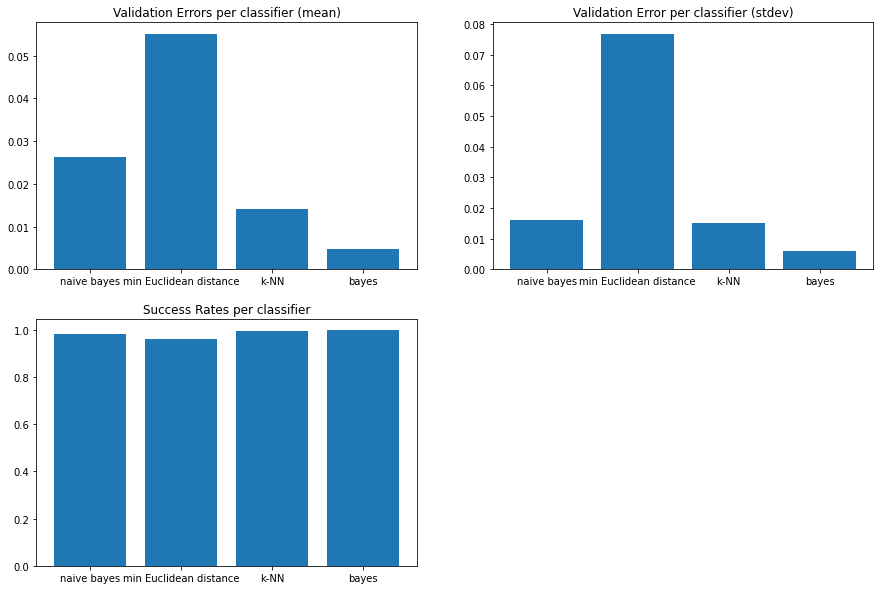

In [80]:
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(221)

ax.set_title('Validation Errors per classifier (mean)')

ax.bar(
    ['naive bayes', 'min Euclidean distance', 'k-NN', 'bayes'], 
    [np.mean(nb_scores), np.mean(mineucl_scores), np.mean(knn_scores), np.mean(bayes_scores)], 
    align='center'
)

ax = fig.add_subplot(222)

ax.set_title('Validation Error per classifier (stdev)')

ax.bar(
    ['naive bayes', 'min Euclidean distance', 'k-NN', 'bayes'], 
    [np.std(nb_scores), np.std(mineucl_scores), np.std(knn_scores), np.std(bayes_scores)], 
    align='center'
)

ax = fig.add_subplot(223)

ax.set_title('Success Rates per classifier')

ax.bar(
    ['naive bayes', 'min Euclidean distance', 'k-NN', 'bayes'], 
    [success_rate(cm1), success_rate(cm2), success_rate(cm3), success_rate(cm4)], 
    align='center'
)

plt.show()

# Combination

Based on the classification results, a "common denominator" of all the classifiers was a slight tendency towards misclassification of: **material no. 5**.

However, there isn't an apparent issue on the spectral unmixing task of material no. 5. Perhaps this is due to fact that materials 3, 4, 5 and 6 are all land-fields that are close to one another. So, when one tries to unmix their spectral signatures, it probably is an easier task than trying to classify their respective image pixels.